### Libraries

In [1]:
import pandas as pd
import numpy as np
import math 
import random
import matplotlib.pyplot as plt

import torch  
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable

### Dataset

In [92]:
tou=np.array(pd.read_csv('tou.csv', header= None));

current_activity=np.array(pd.read_csv('current_activity.csv', header= None), dtype=int); 
duration=np.array(pd.read_csv('duration.csv', header= None), dtype=int); 
previous_activity=np.array(pd.read_csv('previous_activity.csv', header= None), dtype=int); 

AC_status=np.array(pd.read_csv('AC_status.csv', header= None), dtype=int); 

DW_activation_number=np.array(pd.read_csv('DW_activation_number.csv', header= None), dtype=int);
DW_activation_time=np.array(pd.read_csv('DW_activation_time.csv', header= None), dtype=int);

WD_activation_number=np.array(pd.read_csv('WD_activation_number.csv', header= None), dtype=int);
shower_index=np.array(pd.read_csv('shower_index.csv', header= None), dtype=int);
WD_activation_time=np.array(pd.read_csv('WD_activation_time.csv', header= None), dtype=int);

EV_status=np.array(pd.read_csv('EV_status.csv', header= None), dtype=int); 
trip_time=np.array(pd.read_csv('trip_time.csv', header= None), dtype=int);
EV_battery_usage=np.array(pd.read_csv('ev_battery_usage.csv', header= None));
travel_prep=np.array(pd.read_csv('travel_prep.csv', header= None), dtype=int);

### parameters

In [9]:
discomfort_AC=20
discomfort_DW=40
discomfort_WD=50
discomfort_EV=100

Days = 30
Quarters=96;#1440 Minutes in a day, 96 number of 15-minute(Quarter) sequence
GAMMA = 0.9
padding=50; # non-informative addded characters to a string to the ends of it for formatting purposes.

### 1. AC

In [51]:
class AC_Actor(nn.Module):
    def __init__(self, learning_rate=3e-6):
        super(AC_Actor, self).__init__()

        self.num_inputs=1 
        self.num_actions = 2
        
        self.actor_linear1 = nn.Linear(self.num_inputs, 12)
        self.actor_linear2 = nn.Linear(12, 12)
        self.actor_linear3 = nn.Linear(12, self.num_actions)
   
    def forward(self, state):
        state = Variable(torch.from_numpy(state).float())
        policy_dist = self.actor_linear1(state)
        policy_dist = F.relu(self.actor_linear2(policy_dist))                
        policy_dist = F.softmax(self.actor_linear3(policy_dist), dim=1)

        return policy_dist      

In [52]:
class AC_Critic(nn.Module):
    def __init__(self, learning_rate=3e-6):
        super(AC_Critic, self).__init__()

        self.num_inputs=1 
        self.num_actions = 2
        self.critic_linear1 = nn.Linear(self.num_inputs, 12)
        self.critic_linear2 = nn.Linear(12, 12)        
        self.critic_linear3 = nn.Linear(12, 1)
  
    def forward(self, state):
        state = Variable(torch.from_numpy(state).float())
        value = self.critic_linear1(state)
        value = F.relu(self.critic_linear2(value))                
        value = self.critic_linear3(value)

        return value      

episode: 50/ episodes, Average Cost in USD: 5838.49



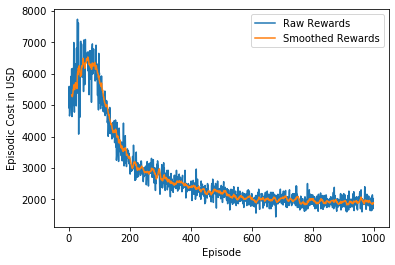

Overall average AC cost: 2786.37
last 10 episode average AC cost: 1892.88
Wall time: 40min 2s


In [53]:
%%time
episodes = 10000

actor_AC = AC_Actor()
critic_AC = AC_Critic()

a_optimizer_AC = optim.Adam(actor_AC.parameters(), lr=3e-6)
c_optimizer_AC = optim.Adam(critic_AC.parameters(), lr=3e-6)

all_costs_AC = []

daily_cost_AC_HERS= np.zeros(Days); # cumulative cost for the system viewed daily

for episode in range(episodes):

	AC_off_counter=0; #counts how long before the AC was off, in multiple of 15 minutes
	AC_discomfort_event=0;

	costs = np.zeros(Days*Quarters)
	instant_power_AC = np.zeros(Days*Quarters+padding)
	AC_cost=np.zeros(30*96)
	algo_cost_AC=np.zeros(30*96)
  
	state_AC= np.zeros((1,1));
   
	for D in range(Days):

		if D % 7== 0 or D % 7== 6:  #  day 1 was sunday             
			wknd=1 # weekend
		else: wknd=0 # weekday 

		for Q in range(Quarters):
                     
			if AC_status[0,D*96+Q]== 1:  
				state_AC[0,0]=AC_off_counter
				policy_dist = actor_AC.forward(state_AC)
				value_AC = critic_AC.forward(state_AC)                
				dist_AC = policy_dist.detach().numpy() # converts tensor to array
				action_AC =np.random.choice(2, p=np.squeeze(dist_AC)) 
				log_prob_AC = torch.log(policy_dist.squeeze(0)[action_AC])
				if  action_AC==0: 
					if AC_off_counter< random.randint(3,4):   # manual turn on
						instant_power_AC[D*96+Q]=np.random.normal(1.8, 0.5)
						AC_cost[D*96+Q]= discomfort_AC+instant_power_AC[D*96+Q]*0.25*tou[wknd,int(np.floor(Q/4))]; #electricity cost                   
						AC_discomfort_event+=1; 
						algo_cost_AC[D*96+Q]=2
                    
					AC_off_counter=0;  
                        
				else:
					instant_power_AC[D*96+Q]=np.random.normal(1.8, 0.5);
					AC_cost[D*96+Q]= instant_power_AC[D*96+Q]*0.25*tou[wknd,int(np.floor(Q/4))];
					AC_off_counter+=1;
					algo_cost_AC[D*96+Q]=1; #electricity cost

				Qval_AC = algo_cost_AC[D*96+Q]         
				advantage_AC = Qval_AC - value_AC
				actor_loss_AC = (log_prob_AC * advantage_AC).mean()
				critic_loss_AC = 0.5 * advantage_AC.pow(2).mean()
				critic_loss_AC = Variable(critic_loss_AC, requires_grad=True)
				a_optimizer_AC.zero_grad() 
				actor_loss_AC.backward()
				a_optimizer_AC.step()

				c_optimizer_AC.zero_grad() 
				critic_loss_AC.backward()
				c_optimizer_AC.step()
                                                                   
			else:AC_off_counter=0; 
		daily_cost_AC_HERS[D]= sum(AC_cost[D*96:(D+1)*96])      
                    
######### weight update,after an episode  #########        
	all_costs_AC.append(np.sum(AC_cost))

	if episode % 1000== 50:                    
		print("episode: {}/ episodes, Average Cost in USD: {:.2f}\n" .format(episode, np.sum(all_costs_AC)/(episode+1)))
                    
    # Plot results
smoothed_costs_AC = pd.Series.rolling(pd.Series(all_costs_AC), 10).mean()
smoothed_costs_AC = [elem for elem in smoothed_costs_AC]
plt.plot(all_costs_AC,label = 'Raw Rewards')
plt.plot(smoothed_costs_AC, label = 'Smoothed Rewards')
plt.plot()
plt.xlabel('Episode')
plt.ylabel('Episodic Cost in USD')
plt.legend()
plt.show()

print("Overall average AC cost: {:.2f}" .format(np.sum(all_costs_AC)/episodes))
print("last 10 episode average AC cost: {:.2f}" .format(np.sum(all_costs_AC[-10:])/10))


### 2. DW

In [54]:
class DW_Actor(nn.Module):
    def __init__(self, learning_rate=3e-6):
        super(DW_Actor, self).__init__()

        self.num_inputs=18 
        self.num_actions = 18
        
        self.actor_linear1 = nn.Linear(self.num_inputs, 48)
        self.actor_linear2 = nn.Linear(48, 120)
        self.actor_linear3 = nn.Linear(120, 48)
        self.actor_linear4 = nn.Linear(48, self.num_actions)
   
    def forward(self, state):
        state = Variable(torch.from_numpy(state).float())
        policy_dist = self.actor_linear1(state)
        policy_dist = self.actor_linear2(policy_dist)
        policy_dist = F.relu(self.actor_linear3(policy_dist))                
        policy_dist = F.softmax(self.actor_linear4(policy_dist), dim=1)

        return policy_dist      

In [55]:
class DW_Critic(nn.Module):
    def __init__(self, learning_rate=3e-6):
        super(DW_Critic, self).__init__()

        self.num_inputs=18 
        self.num_actions = 18
        self.critic_linear1 = nn.Linear(self.num_inputs, 48)
        self.critic_linear2 = nn.Linear(48, 120)
        self.critic_linear3 = nn.Linear(120, 48)        
        self.critic_linear4 = nn.Linear(48, 1)
  
    def forward(self, state):
        state = Variable(torch.from_numpy(state).float())
        value = self.critic_linear1(state)
        value = self.critic_linear2(value)
        value = F.relu(self.critic_linear3(value))                
        value = self.critic_linear4(value)

        return value      

episode: 50/ episodes, Total Cost in USD: 3.93

episode: 2050/ episodes, Total Cost in USD: 3.42

episode: 4050/ episodes, Total Cost in USD: 3.35

episode: 6050/ episodes, Total Cost in USD: 3.32

episode: 8050/ episodes, Total Cost in USD: 3.31



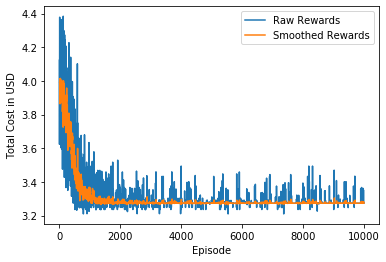

Overall average DW cost: 3.30
last 10 episode DW cost: 3.27
Wall time: 3min 55s


In [87]:
%%time
episodes = 10000

actor_DW = DW_Actor()
critic_DW = DW_Critic()

a_optimizer_DW = optim.Adam(actor_DW.parameters(), lr=3e-6)
c_optimizer_DW = optim.Adam(critic_DW.parameters(), lr=3e-6)

all_costs_DW = []

daily_cost_DW_HERS= np.zeros(Days); # cumulative cost for the system viewed daily
DW_fail=0;
TOU_pool= np.zeros(20); # Next 20 hours electricity price
TOU_3hrs_avg= np.zeros(18); # 3 hrs average electricity price for next 20 hours 

for episode in range(episodes):
    
	dish_done=0; # number of washer and dryer operation
 
	DW_cost=np.zeros(30*96) # actual cost
	algo_cost_DW=np.zeros(30*96) # cost for the RL agent
	instant_power_DW = np.zeros(Days*Quarters+padding)

	state_DW= np.zeros((1,18));
	for D in range(Days):

		if D % 7== 0 or D % 7== 6:  #  day 1 was sunday             
			wknd=1 # weekend
		else: wknd=0 # weekday 

		for Q in range(Quarters):
                                            
			if (DW_activation_number[0,D*96+Q]-dish_done)> 0: ### if DW is in active status
                
				for t in range(20):
					if int(np.floor(Q/4))+t<24:
						TOU_pool[t]= tou[wknd,int(np.floor(Q/4))+t]
						new_day_hour=0;                            
					else:
						if (D+1) % 7== 0 or (D+1) % 7== 6:  #  day 1 was sunday             
							wknd=1 # weekend
						else: wknd=0 # weekday  
						TOU_pool[t]= tou[wknd,new_day_hour]
						new_day_hour+=1;   
                        
                        
					TOU_3hrs_avg= np.convolve(TOU_pool, np.ones(3, dtype=np.int), mode='valid')
					temp = TOU_3hrs_avg.argsort()
					TOU_ranks = np.arange(len(TOU_3hrs_avg))[temp.argsort()]    
                    
				state_DW[0,:]=TOU_ranks+1  
                
				value_DW= critic_DW.forward(state_DW)
				policy_dist = actor_DW.forward(state_DW)                
				dist_DW = policy_dist.detach().numpy() # converts tensor to array
				action_DW =np.random.choice(18, p=np.squeeze(dist_DW))
				log_prob_DW = torch.log(policy_dist.squeeze(0)[action_DW]) 
                
				instant_power_DW[D*96+Q+action_DW:D*96+Q+action_DW+10] = np.random.normal(1.1, 0.0) * np.ones(10)                
				DW_cost[D*96+Q]= instant_power_DW[D*96+Q+action_DW] *2.5*TOU_3hrs_avg[action_DW]/3; #electricity cost
				dish_done+=1;   
				algo_cost_DW[D*96+Q]=TOU_ranks[action_DW]+1
                
				if (DW_activation_number[0,D*96+Q+action_DW+12]-dish_done)> 0: 
					instant_power_DW[D*96+Q+action_DW:D*96+Q+action_DW+10] = np.random.normal(1.1, 0.0) * np.ones(10)                
					DW_cost[D*96+Q]= discomfort_DW+instant_power_DW[D*96+Q+action_DW]*2.5*(TOU_3hrs_avg[action_DW]/3); 
                    # (discomfort cost+electricity cost)+scheduled electricity cost= 2 dishwashing events
					dish_done+=1;
					DW_fail+=1; 
					algo_cost_DW[D*96+Q]=10+TOU_ranks[action_DW]+1                
            
				Qval_DW = algo_cost_DW[D*96+Q]         
				advantage_DW = Qval_DW - value_DW
				actor_loss_DW = (log_prob_DW * advantage_DW).mean()
				critic_loss_DW = 0.5 * advantage_DW.pow(2).mean()
				critic_loss_DW = Variable(critic_loss_DW, requires_grad=True)
				a_optimizer_DW.zero_grad() 
				actor_loss_DW.backward()
				a_optimizer_DW.step()

				c_optimizer_DW.zero_grad() 
				critic_loss_DW.backward()
				c_optimizer_DW.step()
    
    
		daily_cost_DW_HERS[D]= sum(DW_cost[D*96:(D+1)*96])      
                    
	all_costs_DW.append(np.sum(DW_cost))

	if episode % 2000== 50:                    
		print("episode: {}/ episodes, Total Cost in USD: {:.2f}\n" .format(episode, np.sum(all_costs_DW)/(episode+1)))
                        
    # Plot results
smoothed_costs_DW = pd.Series.rolling(pd.Series(all_costs_DW), 10).mean()
smoothed_costs_DW = [elem for elem in smoothed_costs_DW]
plt.plot(all_costs_DW,label = 'Raw Rewards')
plt.plot(smoothed_costs_DW, label = 'Smoothed Rewards')
plt.plot()
plt.xlabel('Episode')
plt.ylabel('Total Cost in USD')
plt.legend()
plt.show()

print("Overall average DW cost: {:.2f}" .format(np.sum(all_costs_DW)/episodes))
print("last 10 episode DW cost: {:.2f}" .format(np.sum(all_costs_DW[-10:])/10))

In [57]:
class WD_Actor(nn.Module):
    def __init__(self, learning_rate=3e-6):
        super(WD_Actor, self).__init__()

        self.num_inputs=18 
        self.num_actions = 18
        
        self.actor_linear1 = nn.Linear(self.num_inputs, 48)
        self.actor_linear2 = nn.Linear(48, 120)
        self.actor_linear3 = nn.Linear(120, 48)
        self.actor_linear4 = nn.Linear(48, self.num_actions)
   
    def forward(self, state):
        state = Variable(torch.from_numpy(state).float())
        policy_dist = self.actor_linear1(state)
        policy_dist = self.actor_linear2(policy_dist)
        policy_dist = F.relu(self.actor_linear3(policy_dist))                
        policy_dist = F.softmax(self.actor_linear4(policy_dist), dim=1)

        return policy_dist      

In [58]:
class WD_Critic(nn.Module):
    def __init__(self, learning_rate=3e-6):
        super(WD_Critic, self).__init__()

        self.num_inputs=18 
        self.num_actions = 18
        self.critic_linear1 = nn.Linear(self.num_inputs, 48)
        self.critic_linear2 = nn.Linear(48, 120)
        self.critic_linear3 = nn.Linear(120, 48)        
        self.critic_linear4 = nn.Linear(48, 1)
  
    def forward(self, state):
        state = Variable(torch.from_numpy(state).float())
        value = self.critic_linear1(state)
        value = self.critic_linear2(value)
        value = F.relu(self.critic_linear3(value))                
        value = self.critic_linear4(value)

        return value      

episode: 50/ episodes, Total Cost in USD: 2.32

episode: 2050/ episodes, Total Cost in USD: 2.14

episode: 4050/ episodes, Total Cost in USD: 2.12

episode: 6050/ episodes, Total Cost in USD: 2.10

episode: 8050/ episodes, Total Cost in USD: 2.07



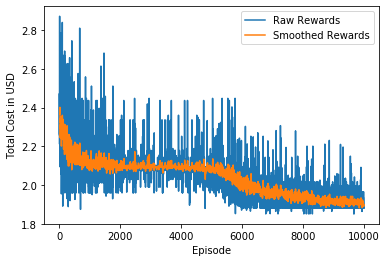

WD cost: 2.04
WD cost: 1.89
Wall time: 2min 22s


In [88]:
%%time
episodes = 10000

actor_WD = WD_Actor()
critic_WD = WD_Critic()

a_optimizer_WD = optim.Adam(actor_WD.parameters(), lr=3e-6)
c_optimizer_WD = optim.Adam(critic_WD.parameters(), lr=3e-6)

all_costs_WD = []

daily_cost_WD_HERS= np.zeros(Days); # cumulative cost for the system viewed yearly
WD_fail=0;
TOU_pool= np.zeros(20); # cumulative cost for the system viewed yearly
TOU_3hrs_avg= np.zeros(18); # cumulative cost for the system viewed yearly

for episode in range(episodes):
    
	cloth_done=0; # number of washer and dryer operation 
	WD_cost=np.zeros(30*96)
	algo_cost_WD=np.zeros(30*96)
	instant_power_WD = np.zeros(Days*Quarters+padding)

	state_WD= np.zeros((1,18));
	for D in range(Days):

		if D % 7== 0 or D % 7== 6:  #  day 1 was sunday             
			wknd=1 # weekend
		else: wknd=0 # weekday 

		for Q in range(Quarters):
                                            
			if (WD_activation_number[0,D*96+Q]-cloth_done)> 0: ### WD, 3hrs delay for next operation 
                
				for t in range(20):
					if int(np.floor(Q/4))+t<24:
						TOU_pool[t]= tou[wknd,int(np.floor(Q/4))+t]
						new_day_hour=0;                            
					else:
						if (D+1) % 7== 0 or (D+1) % 7== 6:  #  day 1 was sunday             
							wknd=1 # weekend
						else: wknd=0 # weekday  
						TOU_pool[t]= tou[wknd,new_day_hour]
						new_day_hour+=1;   
                        
                        
					TOU_3hrs_avg= np.convolve(TOU_pool, np.ones(3, dtype=np.int), mode='valid')
					temp = TOU_3hrs_avg.argsort()
					TOU_ranks = np.arange(len(TOU_3hrs_avg))[temp.argsort()]    
                    
				state_WD[0,:]=TOU_ranks+1  
                
				value_WD= critic_WD.forward(state_WD)
				policy_dist = actor_WD.forward(state_WD)                
				dist_WD = policy_dist.detach().numpy() # converts tensor to array
				action_WD =np.random.choice(18, p=np.squeeze(dist_WD))
				log_prob_WD = torch.log(policy_dist.squeeze(0)[action_WD]) 
                    
				instant_power_WD[D*96+Q+action_WD:D*96+Q+action_WD+10] = np.random.normal(1.2, 0.0) * np.ones(10)                
				WD_cost[D*96+Q]= instant_power_WD[D*96+Q+action_WD] *2.5*TOU_3hrs_avg[action_WD]/3; #electricity cost

				cloth_done+=1;   
				algo_cost_WD[D*96+Q]=TOU_ranks[action_WD]+1
                
				if (WD_status[0,D*96+Q+action_WD+3]-cloth_done)> 0:  
					instant_power_WD[D*96+Q+action_WD:D*96+Q+action_WD+10] = np.random.normal(1.2, 0.0) * np.ones(10)                
					WD_cost[D*96+Q]= discomfort_WD+instant_power_WD[D*96+Q+action_WD] *2.5*TOU_3hrs_avg[action_WD]/3; #electricity cost

					cloth_done+=1;
					WD_fail+=1; 
					algo_cost_WD[D*96+Q]=100+TOU_ranks[action_WD]+1
                            
				Qval_WD = algo_cost_WD[D*96+Q]         
				advantage_WD = Qval_WD - value_WD
				actor_loss_WD = (log_prob_WD * advantage_WD).mean()
				critic_loss_WD = 0.5 * advantage_WD.pow(2).mean()
				critic_loss_WD = Variable(critic_loss_WD, requires_grad=True)
				a_optimizer_WD.zero_grad() 
				actor_loss_WD.backward()
				a_optimizer_WD.step()

				c_optimizer_WD.zero_grad() 
				critic_loss_WD.backward()
				c_optimizer_WD.step()
    
    
		daily_cost_WD_HERS[D]= sum(WD_cost[D*96:(D+1)*96])      
                    
	all_costs_WD.append(np.sum(WD_cost))

	if episode % 2000== 50:                    
		print("episode: {}/ episodes, Total Cost in USD: {:.2f}\n" .format(episode, np.sum(all_costs_WD)/(episode+1)))
                        
    # Plot results
smoothed_costs_WD = pd.Series.rolling(pd.Series(all_costs_WD), 10).mean()
smoothed_costs_WD = [elem for elem in smoothed_costs_WD]
plt.plot(all_costs_WD,label = 'Raw Rewards')
plt.plot(smoothed_costs_WD, label = 'Smoothed Rewards')
plt.plot()
plt.xlabel('Episode')
plt.ylabel('Total Cost in USD')
plt.legend()
plt.show()

print("WD cost: {:.2f}" .format(np.sum(all_costs_WD)/episodes))
print("WD cost: {:.2f}" .format(np.sum(all_costs_WD[-10:])/10))

#torch.save(actor_critic_WD.state_dict(), "./actor_critic_WD.h5")


In [63]:
class EV_Actor(nn.Module):
    def __init__(self, learning_rate=3e-6):
        super(EV_Actor, self).__init__()

        self.num_inputs=3 
        self.num_actions = 5
        
        self.actor_linear1 = nn.Linear(self.num_inputs, 48)
        self.actor_linear2 = nn.Linear(48, 120)
        self.actor_linear3 = nn.Linear(120, 48)
        self.actor_linear4 = nn.Linear(48, self.num_actions)
   
    def forward(self, state):
        state = Variable(torch.from_numpy(state).float())
        policy_dist = self.actor_linear1(state)
        policy_dist = self.actor_linear2(policy_dist)
        policy_dist = F.relu(self.actor_linear3(policy_dist))                
        policy_dist = F.softmax(self.actor_linear4(policy_dist), dim=1)

        return policy_dist      

In [64]:
class EV_Critic(nn.Module):
    def __init__(self, learning_rate=3e-6):
        super(EV_Critic, self).__init__()

        self.num_inputs=3
        self.num_actions = 5
        self.critic_linear1 = nn.Linear(self.num_inputs, 48)
        self.critic_linear2 = nn.Linear(48, 120)
        self.critic_linear3 = nn.Linear(120, 48)        
        self.critic_linear4 = nn.Linear(48, 1)
  
    def forward(self, state):
        state = Variable(torch.from_numpy(state).float())
        value = self.critic_linear1(state)
        value = self.critic_linear2(value)
        value = F.relu(self.critic_linear3(value))                
        value = self.critic_linear4(value)

        return value      

### scene 1

episode: 50/ episodes, EV Cost in USD: 56.38



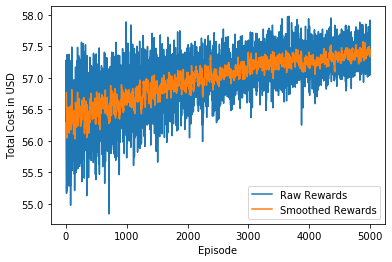

EV cost: 56.99
EV cost: 57.44


In [93]:
#%%time
episodes = 10000

actor_EV = EV_Actor()
critic_EV = EV_Critic()

a_optimizer_EV = optim.Adam(actor_EV.parameters(), lr=3e-6)
c_optimizer_EV = optim.Adam(critic_EV.parameters(), lr=3e-6)

all_costs_EV = []

daily_cost_EV_HERS= np.zeros(Days); # cumulative cost for the system viewed yearly
for episode in range(episodes):
	EV_fail=0;  
	trip=0;
	EV_in_home=0; # counts how long the EV returned home    
	log_probs_EV = []; # log probabilities of action
	values_EV = []

	costs_EV=[]
	algo_cost_EV=np.zeros(30*96); # lowest tariff full charging costs 10c87.68*0.25(hr)= 19.2 cents
	EV_cost=np.zeros(30*96)

	battery=0.5;# EV battery charge level
	EV_battery_status = np.ones(30*96+1)
	EV_battery_status[0]= battery
	EV_status_copy= np.copy(EV_status)    

	state_EV= np.zeros((1,3));
   
	for D in range(Days):

		if D % 7== 0 or D % 7== 6:  #  day 1 was sunday             
			wknd=1 # weekend
		else: wknd=0 # weekday 

		for Q in range(Quarters):
                       
			if EV_status_copy[0,(D*96+Q)*15]== 0 and EV_battery_status[D*96+Q]<0.98: ### if EV at home and less than 98% charged, with 7.68 KW charge rate, 15 minute charging is 3.84%, so it also restricts the charge go above 101.84%   
				state_EV[0,0]=EV_battery_status[D*96+Q]/(travel_prep[0,D*96+Q]+1) 
				state_EV[0,1]=tou[wknd,int(np.floor(Q/4))]/0.27
				state_EV[0,2]=EV_in_home/52
                
				value= critic_EV.forward(state_EV);
				policy_dist = actor_EV.forward(state_EV);                                                             
				dist_EV = policy_dist.detach().numpy() # converts tensor to array
				action_EV =np.random.choice(5, p=np.squeeze(dist_EV))
				log_prob_EV = torch.log(policy_dist.squeeze(0)[action_EV])
				log_probs_EV.append(log_prob_EV)  
				values_EV.append(value)                    
				EV_cost[D*96+Q]= 1.92*action_EV*0.25*tou[wknd,int(np.floor(Q/4))]; #electricity cost for EV range 0-7.68 kW
                
#				algo_cost_EV[D*96+Q]= pow(tou[wknd,int(np.floor(Q/4))]/0.1,action_EV); 
                
				if  tou[wknd,int(np.floor(Q/4))]<0.15: # encourages to carge at lowest tariff, full charging costs 10c87.68*0.25(hr)= 19.2 cents
					algo_cost_EV[D*96+Q]= 1/(action_EV+1); 
				else: algo_cost_EV[D*96+Q]= action_EV*tou[wknd,int(np.floor(Q/4))]+EV_in_home/(52*battery);                    
                    
				battery+= 1.92*action_EV*0.25/50; # 50 kWh is full battery
				EV_battery_status[D*96+Q+1]= battery
				EV_in_home+=1;
				if  EV_battery_status[D*96+Q+1]< 0.4  and EV_status_copy[0,(D*96+Q)*15+15]== 1 and travel_prep[0,D*96+Q]==0: 
					EV_cost[D*96+Q]+= discomfort_EV; #electricity cost
					algo_cost_EV[D*96+Q]+= 1000; 
                    
					EV_battery_status[D*96+Q+1]= battery
					EV_status_copy[0,(D*96+Q)*15+15:((D*96+Q)*15+15+trip_time[0,trip])]  = np.zeros(trip_time[0,trip])                      
					trip+=1;                    
					EV_fail+=1;
				if  EV_battery_status[D*96+Q+1]< 0.7  and EV_status_copy[0,(D*96+Q)*15+15]== 1 and travel_prep[0,D*96+Q]==1: 
					EV_cost[D*96+Q]+= 3* discomfort_EV; #electricity cost
					algo_cost_EV[D*96+Q]+= 1000; 
                    
					EV_battery_status[D*96+Q+1]= battery 
					EV_status_copy[0,(D*96+Q)*15+15:((D*96+Q)*15+trip_time[0,trip]+15)]  = np.zeros(trip_time[0,trip])                      
					trip+=1; 
					EV_fail+=1;
				costs_EV.append(algo_cost_EV[D*96+Q])
                    
			if EV_status_copy[0,(D*96+Q)*15]== 1 and EV_status_copy[0,(D*96+Q)*15+15]== 0: ### if EV returns from trip 
				state_EV[0,0]=EV_battery_status[D*96+Q]/(travel_prep[0,D*96+Q]+1) # state includes both battery status and upcoming travel
				state_EV[0,1]=tou[wknd,int(np.floor(Q/4))]/0.27
				state_EV[0,2]=EV_in_home/52
				Qval_EV= critic_EV.forward(state_EV)
				Qval_EV=  Qval_EV.detach().numpy() 
				Qvals_EV = np.zeros(len(costs_EV))
				for t in reversed(range(len(costs_EV))):
					Qval_EV = costs_EV[t]+ GAMMA * Qval_EV
					Qvals_EV[t] = Qval_EV         
				values_EV = torch.FloatTensor(values_EV)
				Qvals_EV = torch.FloatTensor(Qvals_EV)
				log_probs_EV = torch.stack(log_probs_EV)        
				advantage_EV = Qvals_EV - values_EV
				actor_loss_EV = (log_probs_EV * advantage_EV).mean()
				critic_loss_EV = 0.5 * advantage_EV.pow(2).mean()
				critic_loss_EV = Variable(critic_loss_EV, requires_grad=True)
				a_optimizer_EV.zero_grad() 
				actor_loss_EV.backward()
				a_optimizer_EV.step()

				c_optimizer_EV.zero_grad() 
				critic_loss_EV.backward()
				c_optimizer_EV.step()  
                
				log_probs_EV = []; # log probabilities of action
				values_EV = []
				costs_EV=[] 
                 
				battery-= EV_battery_usage[0,trip]                
				EV_battery_status[D*96+Q+1]= battery
				trip+=1; 
				EV_in_home=0;

		daily_cost_EV_HERS[D]= sum(EV_cost[D*96:(D+1)*96])                      
	all_costs_EV.append(np.sum(EV_cost))

	if episode % 10000== 50:                    
		print("episode: {}/ episodes, EV Cost in USD: {:.2f}\n" .format(episode, np.sum(all_costs_EV)/(episode+1)))
                                             
    # Plot results
smoothed_costs_EV = pd.Series.rolling(pd.Series(all_costs_EV), 10).mean()
smoothed_costs_EV = [elem for elem in smoothed_costs_EV]
plt.plot(all_costs_EV,label = 'Raw Rewards')
plt.plot(smoothed_costs_EV, label = 'Smoothed Rewards')
plt.plot()
plt.xlabel('Episode')
plt.ylabel('Total Cost in USD')
plt.legend()
plt.show()

print("EV cost: {:.2f}" .format(np.sum(all_costs_EV)/episodes))
print("EV cost: {:.2f}" .format(np.sum(all_costs_EV[-10:])/10))

### scene-2

episode: 50/ episodes, EV Cost in USD: 56.27



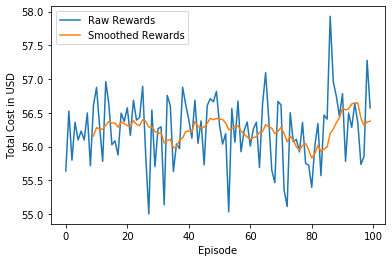

EV cost: 56.25
EV cost: 56.38
Wall time: 23.6 s


In [94]:
%%time

episodes = 10000

actor_EV = EV_Actor()
critic_EV = EV_Critic()

a_optimizer_EV = optim.Adam(actor_EV.parameters(), lr=3e-6)
c_optimizer_EV = optim.Adam(critic_EV.parameters(), lr=3e-6)

all_costs_EV2 = []
daily_cost_EV2_HERS= np.zeros(Days); # cumulative cost for the system viewed yearly
instant_power_others=instant_power_AC+instant_power_DW+instant_power_WD
for episode in range(episodes):
	EV_fail=0;  
	trip=0;
	EV_in_home=0; # counts how long the EV returned home    
	log_probs_EV = []; # log probabilities of action
	values_EV = []

	costs_EV=[]
	algo_cost_EV=np.zeros(30*96); # lowest tariff full charging costs 10c87.68*0.25(hr)= 19.2 cents
	EV_cost2=np.zeros(30*96)
	instant_power_EV2=np.zeros(30*96)

	battery=0.5;
	EV_battery_status = np.ones(30*96+1)
	EV_battery_status[0]= battery 
	EV_status_copy= np.copy(EV_status)    

	state_EV= np.zeros((1,3));
   
	for D in range(Days):

		if D % 7== 0 or D % 7== 6:  #  day 1 was sunday             
			wknd=1 # weekend
		else: wknd=0 # weekday 

		for Q in range(Quarters):
                       
			if EV_status_copy[0,(D*96+Q)*15]== 0 and EV_battery_status[D*96+Q]<0.98: ### if EV at home and less than 98% charged, with 7.68 KW charge rate, 15 minute charging is 3.84%, so it also restricts the charge go above 101.84%   
				state_EV[0,0]=EV_battery_status[D*96+Q]/(travel_prep[0,D*96+Q]+1) 
				state_EV[0,1]=tou[wknd,int(np.floor(Q/4))]/0.27
				state_EV[0,2]=EV_in_home/52
                
				value= critic_EV.forward(state_EV);
				policy_dist = actor_EV.forward(state_EV);                                                             
				dist_EV = policy_dist.detach().numpy() # converts tensor to array
				action_EV =np.random.choice(5, p=np.squeeze(dist_EV))
				log_prob_EV = torch.log(policy_dist.squeeze(0)[action_EV])
				log_probs_EV.append(log_prob_EV)  
				values_EV.append(value)                    
				instant_power_EV2[D*96+Q]=min(1.92*action_EV,10-instant_power_others[D*96+Q]);# 10Kw TOTAL LOAD        
				EV_cost2[D*96+Q]= instant_power_EV2[D*96+Q]*0.25*tou[wknd,int(np.floor(Q/4))]; 
#				algo_cost_EV[D*96+Q]= pow(tou[wknd,int(np.floor(Q/4))]/0.1,action_EV); 
                
				if  tou[wknd,int(np.floor(Q/4))]<0.15: # encourages to carge at lowest tariff, full charging costs 10c87.68*0.25(hr)= 19.2 cents
					algo_cost_EV[D*96+Q]= 1/(action_EV+1); 
				else: algo_cost_EV[D*96+Q]= action_EV*tou[wknd,int(np.floor(Q/4))]+EV_in_home/(52*battery);                    
                    
				battery+= instant_power_EV2[D*96+Q]*0.25/50; # 50 kWh is full battery
				EV_battery_status[D*96+Q+1]= battery
				EV_in_home+=1;
				if  EV_battery_status[D*96+Q+1]< 0.4  and EV_status_copy[0,(D*96+Q)*15+15]== 1 and travel_prep[0,D*96+Q]==0: 
					EV_cost2[D*96+Q]+= discomfort_EV; #electricity cost
					algo_cost_EV[D*96+Q]+= 1000; 
                    
					EV_battery_status[D*96+Q+1]= battery
					EV_status_copy[0,(D*96+Q)*15+15:((D*96+Q)*15+15+trip_time[0,trip])]  = np.zeros(trip_time[0,trip])                      
					trip+=1;                    
					EV_fail+=1;
				if  EV_battery_status[D*96+Q+1]< 0.7  and EV_status_copy[0,(D*96+Q)*15+15]== 1 and travel_prep[0,D*96+Q]==1: 
					EV_cost2[D*96+Q]+= 3* discomfort_EV; #electricity cost
					algo_cost_EV[D*96+Q]+= 1000; 
                    
					EV_battery_status[D*96+Q+1]= battery 
					EV_status_copy[0,(D*96+Q)*15+15:((D*96+Q)*15+trip_time[0,trip]+15)]  = np.zeros(trip_time[0,trip])                      
					trip+=1; 
					EV_fail+=1;
				costs_EV.append(algo_cost_EV[D*96+Q])
                    
			if EV_status_copy[0,(D*96+Q)*15]== 1 and EV_status_copy[0,(D*96+Q)*15+15]== 0: ### if EV returns from trip 
				state_EV[0,0]=EV_battery_status[D*96+Q]/(travel_prep[0,D*96+Q]+1) 
				state_EV[0,1]=tou[wknd,int(np.floor(Q/4))]/0.27
				state_EV[0,2]=EV_in_home/52
				Qval_EV= critic_EV.forward(state_EV)
				Qval_EV=  Qval_EV.detach().numpy() 
				Qvals_EV = np.zeros(len(costs_EV))
				for t in reversed(range(len(costs_EV))):
					Qval_EV = costs_EV[t]+ GAMMA * Qval_EV
					Qvals_EV[t] = Qval_EV         
				values_EV = torch.FloatTensor(values_EV)
				Qvals_EV = torch.FloatTensor(Qvals_EV)
				log_probs_EV = torch.stack(log_probs_EV)        
				advantage_EV = Qvals_EV - values_EV
				actor_loss_EV = (log_probs_EV * advantage_EV).mean()
				critic_loss_EV = 0.5 * advantage_EV.pow(2).mean()
				critic_loss_EV = Variable(critic_loss_EV, requires_grad=True)
				a_optimizer_EV.zero_grad() 
				actor_loss_EV.backward()
				a_optimizer_EV.step()

				c_optimizer_EV.zero_grad() 
				critic_loss_EV.backward()
				c_optimizer_EV.step()  
                
				log_probs_EV = []; # log probabilities of action
				values_EV = []
				costs_EV=[] 
                 
				battery-= EV_battery_usage[0,trip]                
				EV_battery_status[D*96+Q+1]= battery
				trip+=1; 
				EV_in_home=0;

		daily_cost_EV2_HERS[D]= sum(EV_cost2[D*96:(D+1)*96])      
                
	all_costs_EV2.append(np.sum(EV_cost2))

	if episode % 10000== 50:                    
		print("episode: {}/ episodes, EV Cost in USD: {:.2f}\n" .format(episode, np.sum(all_costs_EV2)/(episode+1)))
                                             
    # Plot results
smoothed_costs_EV = pd.Series.rolling(pd.Series(all_costs_EV2), 10).mean()
smoothed_costs_EV = [elem for elem in smoothed_costs_EV]
plt.plot(all_costs_EV2,label = 'Raw Rewards')
plt.plot(smoothed_costs_EV, label = 'Smoothed Rewards')
plt.plot()
plt.xlabel('Episode')
plt.ylabel('Total Cost in USD')
plt.legend()
plt.show()

print("EV cost: {:.2f}" .format(np.sum(all_costs_EV2)/episodes))
print("EV cost: {:.2f}" .format(np.sum(all_costs_EV2[-10:])/10))



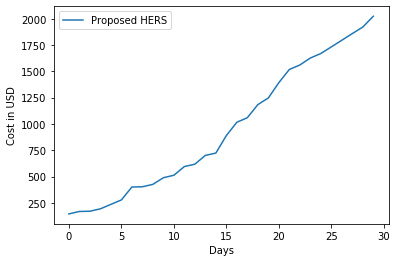

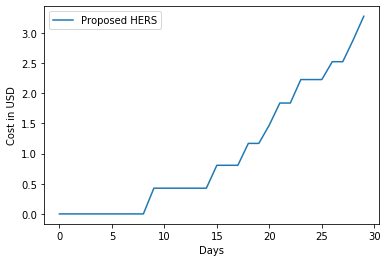

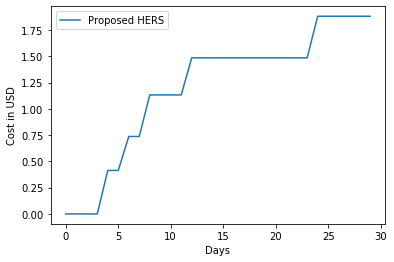

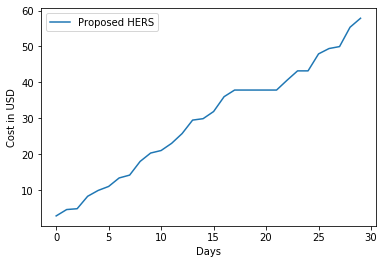

In [95]:
plt.figure(1)
plt.plot(daily_cost_AC_HERS.cumsum(), label = 'Proposed HERS')
plt.xlabel('Days')
plt.ylabel('Cost in USD')
plt.legend()
plt.savefig('AC.pdf')

plt.figure(2)
plt.plot(daily_cost_DW_HERS.cumsum(), label = 'Proposed HERS')
plt.xlabel('Days')
plt.ylabel('Cost in USD')
plt.legend()
plt.savefig('DW.pdf')

plt.figure(3)
plt.plot(daily_cost_WD_HERS.cumsum(), label = 'Proposed HERS')
plt.xlabel('Days')
plt.ylabel('Cost in USD')
plt.legend()
plt.savefig('WD.pdf')

plt.figure(4)
plt.plot(daily_cost_EV_HERS.cumsum(), label = 'Proposed HERS')
plt.xlabel('Days')
plt.ylabel('Cost in USD')
plt.legend()
plt.savefig('EV.pdf')


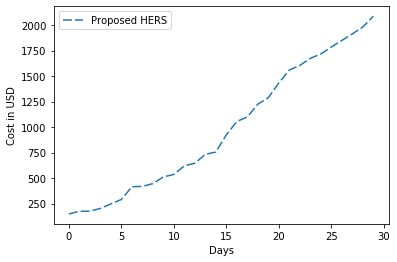

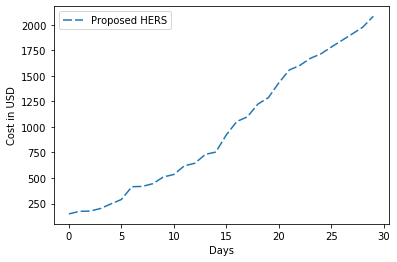

In [96]:
daily_cost_HERS=daily_cost_DW_HERS+ daily_cost_WD_HERS+daily_cost_AC_HERS+daily_cost_EV_HERS
daily_cost_HERS2=daily_cost_DW_HERS+ daily_cost_WD_HERS+daily_cost_AC_HERS+daily_cost_EV2_HERS

plt.figure(1)
plt.plot(daily_cost_HERS.cumsum(),dashes=[6, 2], label = 'Proposed HERS')
plt.xlabel('Days')
plt.ylabel('Cost in USD')
plt.legend()
plt.savefig('scene-1.pdf')

plt.figure(2)
plt.plot(daily_cost_HERS2.cumsum(),dashes=[6, 2], label = 'Proposed HERS')
plt.xlabel('Days')
plt.ylabel('Cost in USD')
plt.legend()
plt.savefig('scene-2.pdf')